In [2]:
from dataclasses import dataclass, field

import numpy as np
import scipy
import scipy.optimize
from geopy.distance import geodesic


@dataclass
class BoatProperties:
    area_anchor: float
    area_water_front: float
    area_water_side: float
    area_air_front: float
    area_air_side: float
    drag_coefficient_air: float
    drag_coefficient_water: float
    speed_perfect: float
    force_row: float = field(init=False)

    def __post_init__(self):
        self.force_row = calculate_row_force_perfect_conditions(
            self.area_air_front,
            self.area_water_front,
            self.drag_coefficient_air,
            self.drag_coefficient_water,
            self.speed_perfect,
        )


@dataclass
class BoatState:
    lon: float
    lat: float
    time: np.datetime64
    orientation: float = 0.0
    V_boat: np.ndarray = field(default_factory=lambda: np.zeros(2))
    V_water: np.ndarray = field(default_factory=lambda: np.zeros(2))
    V_air: np.ndarray = field(default_factory=lambda: np.zeros(2))
    row: bool = True
    anchor: bool = False

    # @property
    # def heading_boat(self) -> float:
    #     return np.arctan2(self.v_boat, self.u_boat)

    # @property
    # def heading_air(self) -> float:
    #     return np.arctan2(self.v_air, self.u_air)

    # @property
    # def heading_water(self) -> float:
    #     return np.arctan2(self.v_water, self.u_water)


def calculate_row_force_perfect_conditions(
    area_air_front: float,
    area_water_front: float,
    drag_coefficient_air: float,
    drag_coefficient_water: float,
    speed_perfect: float,
) -> float:
    drag_air = 0.5 * area_air_front * drag_coefficient_air * speed_perfect**2
    drag_water = 0.5 * area_water_front * drag_coefficient_water * speed_perfect**2
    return drag_air + drag_water


def calculate_effective_area(
    area_front: float, area_side: float, angle: float
) -> float:
    return area_front * np.cos(angle) ** 2 + area_side * np.sin(angle) ** 2


def calculate_drag_air(
    boat_properties: BoatProperties,
    V_air: np.ndarray,
    V_boat: np.ndarray,
    orientation: float,
) -> np.ndarray:
    V_relative = V_air - V_boat
    speed_relative = np.linalg.norm(V_relative)
    heading_relative = np.arctan2(V_relative[1], V_relative[0])
    heading_reference = heading_relative - orientation
    effective_area = calculate_effective_area(
        boat_properties.area_air_front, boat_properties.area_air_side, heading_reference
    )
    drag_force = (
        0.5 * boat_properties.drag_coefficient_air * speed_relative**2 * effective_area
    )
    drag_parallel = drag_force * np.cos(heading_reference)
    return drag_parallel * np.array([np.cos(orientation), np.sin(orientation)])


def calculate_drag_water_no_currents(
    boat_properties: BoatProperties,
    V_boat: np.ndarray,
    orientation: float,
) -> np.ndarray:
    speed = np.linalg.norm(V_boat)
    V_relative = -V_boat
    heading_relative = np.arctan2(V_relative[1], V_relative[0])
    heading_reference = heading_relative - orientation
    effective_area = calculate_effective_area(
        boat_properties.area_water_front,
        boat_properties.area_water_side,
        heading_reference,
    )
    drag_force = (
        0.5 * boat_properties.drag_coefficient_water * speed**2 * effective_area
    )
    return drag_force * np.array([np.cos(heading_relative), np.sin(heading_relative)])


def calculate_row_force(
    boat_properties: BoatProperties, orientation: float, row: bool
) -> np.ndarray:
    return (
        boat_properties.force_row
        * np.array([np.cos(orientation), np.sin(orientation)])
        * int(row)
    )


def calculate_total_force_no_currents(
    V_boat: float,
    V_air: np.ndarray,
    orientation: float,
    row: bool,
    boat_properties: BoatProperties,
) -> list[float, float]:
    drag_air = calculate_drag_air(boat_properties, V_air, V_boat, orientation)
    drag_water = calculate_drag_water_no_currents(boat_properties, V_boat, orientation)
    force_row = calculate_row_force(boat_properties, orientation, row)
    return force_row + drag_air + drag_water


def solve_boat_velocity(
    boat_properties: BoatProperties,
    V_water: np.ndarray,
    V_air: np.ndarray,
    orientation: float,
    row: bool,
) -> tuple[float, float]:
    V_boat_relative_guess = V_water + boat_properties.speed_perfect * np.array(
        [np.cos(orientation), np.sin(orientation)]
    )
    V_air_relative = V_air - V_water
    args = (
        V_air_relative,
        orientation,
        row,
        boat_properties,
    )
    V_boat_relative_solution = scipy.optimize.root(
        calculate_total_force_no_currents,
        V_boat_relative_guess,
        args=args,
        tol=1e-4,
    )
    if not V_boat_relative_solution.success:
        raise ValueError(f"Optimization failed: {V_boat_relative_solution.message}")
    V_boat_relative = V_boat_relative_solution.x
    return V_boat_relative + V_water


def displace_lon_lat_geopy(lon, lat, x, y):
    start = (lat, lon)
    new_point = geodesic(meters=y).destination(start, 0)  # North
    new_lat, new_lon = new_point.latitude, new_point.longitude
    new_point = geodesic(meters=x).destination((new_lat, new_lon), 90)  # East
    return new_point.latitude, new_point.longitude


def move_boat(boat_state: BoatState, time_step: float) -> BoatState:
    x = boat_state.V_boat[0] * time_step
    y = boat_state.V_boat[1] * time_step
    new_lat, new_lon = displace_lon_lat_geopy(boat_state.lon, boat_state.lat, x, y)
    new_time = boat_state.time + np.timedelta64(int(time_step), "s")
    return BoatState(lon=new_lon, lat=new_lat, time=new_time)

boat_state = BoatState(
    lon=10,
    lat=20,
    orientation=0,
    time=np.datetime64("now"),
    V_boat=np.array([0, 0]),
    V_air=np.array([0, 0]),
    V_water=np.array([0, 0]),
    row=False,
)
print(boat_state)

boat_properties = BoatProperties(
    area_anchor=6,
    area_air_front=4,
    area_water_front=1,
    area_water_side=7,
    area_air_side=8,
    drag_coefficient_air=0.4,
    drag_coefficient_water=20,
    speed_perfect=2,
)
print(boat_properties)

row_force = calculate_row_force(
    boat_properties, boat_state.orientation, boat_state.row
)
print(f"{row_force[0]=:.2f}, {row_force[1]=:.2f}")

effective_area_air = calculate_effective_area(
    boat_properties.area_air_front,
    boat_properties.area_air_side,
    boat_state.orientation,
)
print(f"{effective_area_air=:.2f}")

drag_air = calculate_drag_air(
    boat_properties,
    boat_state.V_air,
    boat_state.V_boat,
    boat_state.orientation,
)
print(f"{drag_air[0]=:.2f}, {drag_air[1]=:.2f}")

drag_water = calculate_drag_water_no_currents(
    boat_properties, boat_state.V_boat, boat_state.orientation
)
print(f"{drag_water[0]=:.2f}, {drag_water[1]=:.2f}")

total_force = calculate_total_force_no_currents(
    boat_state.V_boat,
    boat_state.V_air,
    boat_state.orientation,
    boat_state.row,
    boat_properties,
)
print(f"{total_force[0]=:.2f}, {total_force[1]=:.2f}")

V_boat = solve_boat_velocity(boat_properties, boat_state.V_water, boat_state.V_air, boat_state.orientation, boat_state.row)
print(f"{V_boat[0]=:.2f}, {V_boat[1]=:.2f}")

boat_state.V_boat = V_boat

new_boat_state = move_boat(boat_state, 3600 * 24)
print(new_boat_state)


BoatState(lon=10, lat=20, time=numpy.datetime64('2025-02-19T07:19:32'), orientation=0, V_boat=array([0, 0]), V_water=array([0, 0]), V_air=array([0, 0]), row=False, anchor=False)
BoatProperties(area_anchor=6, area_water_front=1, area_water_side=7, area_air_front=4, area_air_side=8, drag_coefficient_air=0.4, drag_coefficient_water=20, speed_perfect=2, force_row=43.2)
row_force[0]=0.00, row_force[1]=0.00
effective_area_air=4.00
drag_air[0]=0.00, drag_air[1]=0.00
drag_water[0]=0.00, drag_water[1]=0.00
total_force[0]=0.00, total_force[1]=0.00


ValueError: Optimization failed: The number of calls to function has reached maxfev = 600.

In [10]:
vx = np.linspace(-10,10,100)
vy = np.linspace(-10,10,100)

Vx,Vy = np.meshgrid(vx,vy)
Fx,Fy = np.zeros_like(Vx), np.zeros_like(Vy)

for i in np.arange(len(vx)):
    for j in np.arange(len(vy)):
        Fx[j,i], Fy[j,i] = calculate_total_force_no_currents(np.array([Vx[j,i],Vy[j,i]]), boat_state.V_air, boat_state.orientation, boat_state.row,boat_properties)

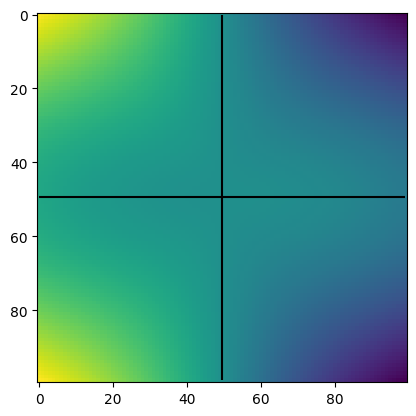

In [17]:
import matplotlib.pyplot as plt

plt.imshow(Fx)
plt.contour(Fx,0,colors=['k'])
plt.contour(Fy,0,colors=['k'])

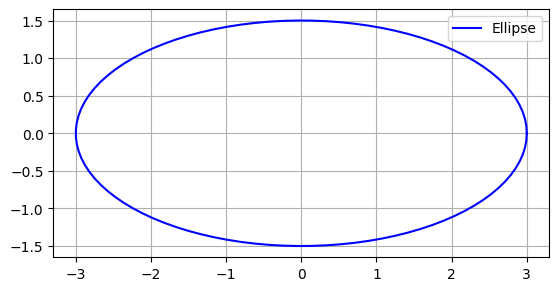

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Define ellipse parameters
width = 6
height = 3
angle = 30  # Rotation angle in degrees

# Generate ellipse points
t = np.linspace(0, 2 * np.pi, 100)
x = (width / 2) * np.cos(t)
y = (height / 2) * np.sin(t)


# Plot
plt.plot(x, y, 'b', label="Ellipse")
plt.gca().set_aspect('equal')
plt.grid()
plt.legend()
plt.show()
